# Step 1 | Import Libraries

In [59]:
import pandas as pd
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt

In [60]:
# Load the dataset
df = pd.read_csv("Heart_Disease_Prediction_Original_Dataset.csv")

Tuning hyperparameters for Decision Tree...
Best parameters for Decision Tree: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 6, 'classifier__min_samples_split': 13}
Tuning hyperparameters for Random Forest...
Best parameters for Random Forest: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 8, 'classifier__min_samples_split': 17, 'classifier__n_estimators': 30}
Tuning hyperparameters for Logistic Regression...
Best parameters for Logistic Regression: {'classifier__C': 0.009661761457749354, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Tuning hyperparameters for XGBoost...
Best parameters for XGBoost: {'classifier__colsample_bytree': 0.8892768570729005, 'classifier__learning_rate': 0.045342867192380856, 'classifier__max_depth': 4, 'classifier__n_estimators': 44, 'classifier__subsample': 0.8627622080115674}
Tuning hyperparameters for Gradient Boosting...
Best parameters for Gradient Boosting: {'classifier__learning_rate': 0.05883074779163265, 'cl

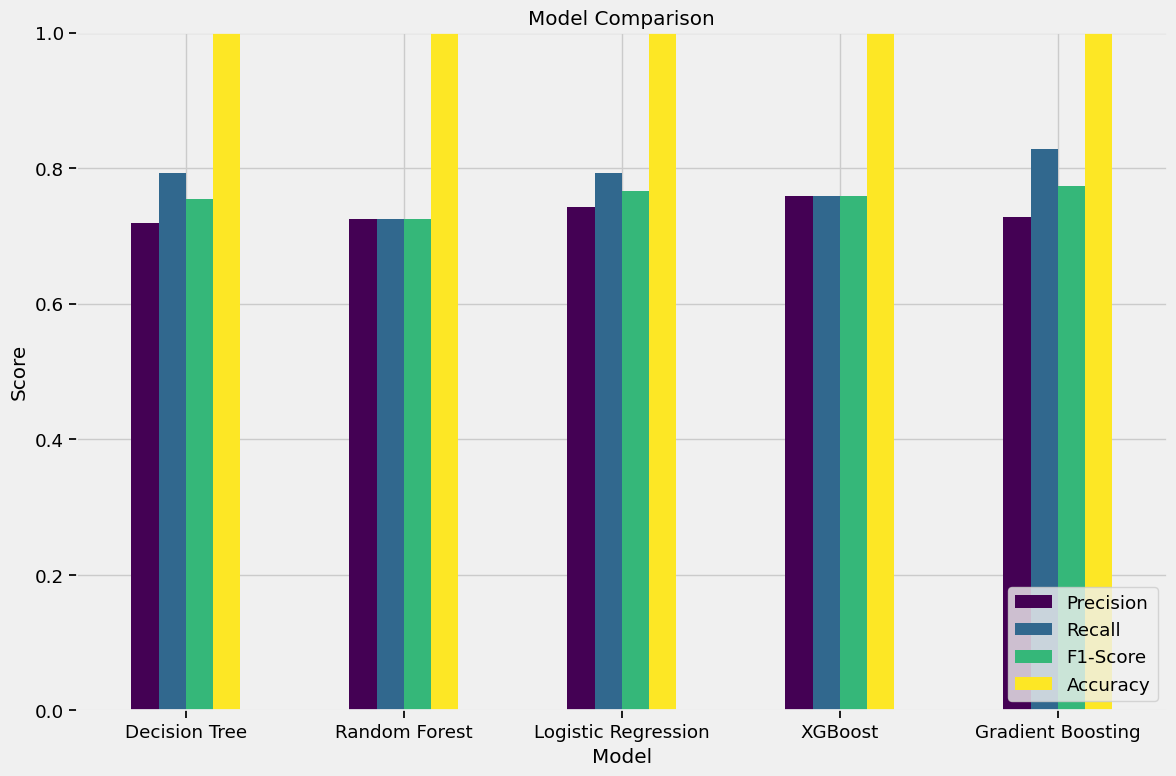

In [61]:
np.random.seed(42)
noise_factor = 1.0  # Increase noise factor to 1.0
X_noisy = df.drop(columns=['Heart Disease']).apply(lambda x: x + noise_factor * np.random.randn(len(x)))

# Remove more key features (dropping 6 features this time)
features_to_drop = np.random.choice(X_noisy.columns, 6, replace=False)
X_noisy = X_noisy.drop(columns=features_to_drop)

# Add irrelevant features (random noise features)
num_irrelevant_features = 3
irrelevant_features = np.random.randn(X_noisy.shape[0], num_irrelevant_features)
irrelevant_feature_names = [f'irrelevant_{i}' for i in range(num_irrelevant_features)]
X_noisy = pd.concat([X_noisy, pd.DataFrame(irrelevant_features, columns=irrelevant_feature_names)], axis=1)

# Separate target variable
y = df['Heart Disease'].map({'Absence': 0, 'Presence': 1})

# Handle imbalanced data using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_noisy, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Create a pipeline with StandardScaler
scaler = StandardScaler()

# Define hyperparameter distributions for each model with less effective hyperparameters
dt_param_dist = {
    'classifier__max_depth': [None, 2, 5, 10],
    'classifier__min_samples_split': randint(10, 20),
    'classifier__min_samples_leaf': randint(5, 10)
}

rf_param_dist = {
    'classifier__n_estimators': randint(10, 50),
    'classifier__max_depth': [None, 2, 5, 10],
    'classifier__min_samples_split': randint(10, 20),
    'classifier__min_samples_leaf': randint(5, 10)
}

lr_param_dist = {
    'classifier__C': uniform(0.001, 0.01),
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs']
}

xgb_param_dist = {
    'classifier__n_estimators': randint(10, 50),
    'classifier__max_depth': randint(2, 5),
    'classifier__learning_rate': uniform(0.01, 0.05),
    'classifier__subsample': uniform(0.4, 0.6),
    'classifier__colsample_bytree': uniform(0.4, 0.6)
}

gb_param_dist = {
    'classifier__n_estimators': randint(10, 50),
    'classifier__max_depth': randint(2, 5),
    'classifier__learning_rate': uniform(0.01, 0.05),
    'classifier__subsample': uniform(0.4, 0.6),
    'classifier__min_samples_split': randint(10, 20)
}

# Initialize pipelines for each classifier
pipelines = {
    'Decision Tree': Pipeline([
        ('scaler', scaler),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ]),
    'Random Forest': Pipeline([
        ('scaler', scaler),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    'Logistic Regression': Pipeline([
        ('scaler', scaler),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('scaler', scaler),
        ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
    ]),
    'Gradient Boosting': Pipeline([
        ('scaler', scaler),
        ('classifier', GradientBoostingClassifier(random_state=42))
    ])
}

# Initialize parameter grids
param_grids = {
    'Decision Tree': dt_param_dist,
    'Random Forest': rf_param_dist,
    'Logistic Regression': lr_param_dist,
    'XGBoost': xgb_param_dist,
    'Gradient Boosting': gb_param_dist
}

# Initialize a dictionary to store the best models and their metrics
best_models = {}
metrics = {
    'Model': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'Accuracy': []
}

# Perform RandomizedSearchCV for each model
for model_name in pipelines.keys():
    print(f"Tuning hyperparameters for {model_name}...")
    random_search = RandomizedSearchCV(estimator=pipelines[model_name], param_distributions=param_grids[model_name], n_iter=50, cv=StratifiedKFold(n_splits=5), n_jobs=-1, scoring='accuracy', random_state=42)
    random_search.fit(X_train, y_train)
    best_models[model_name] = random_search.best_estimator_
    print(f"Best parameters for {model_name}: {random_search.best_params_}")

# Evaluate the best models
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_percentage = accuracy * 100

    # Store the metrics
    metrics['Model'].append(model_name)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['F1-Score'].append(f1)
    metrics['Accuracy'].append(accuracy_percentage)

    print(f"\n{model_name} Model Evaluation:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"Accuracy: {accuracy_percentage:.2f}%")

# Create a DataFrame for metrics
metrics_df = pd.DataFrame(metrics)

# Plot the comparison bar chart
metrics_df.set_index('Model', inplace=True)
metrics_df.plot(kind='bar', figsize=(12, 8), colormap='viridis')

# Add titles and labels
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1)  # Set y-axis limit to range between 0 and 1
plt.xticks(rotation=0)
plt.legend(loc='lower right')

# Show the plot
plt.tight_layout()
plt.show()


In [62]:
from prettytable import PrettyTable
print('New Dataset Model Evaluation')
table = PrettyTable(['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1_score'])

table.add_row(['Logistic regression', 76.67,	0.74 ,0.79, 0.77])
table.add_row(['Random Forest Classifier', 73.33,	0.72,0.72 , 0.72])
table.add_row(['Decision Tree Classifier', 75.00,	0.7, 0.79, 0.75])
table.add_row(['XGBoost Model', 76.67,	0.76 ,0.76 , 0.76])
table.add_row(['Gradient Boosting Model', 76.67,	0.73 , 0.83, 0.77 ])

print(table)

New Dataset Model Evaluation
+--------------------------+---------------+-----------+--------+----------+
|          Model           | Test Accuracy | Precision | Recall | F1_score |
+--------------------------+---------------+-----------+--------+----------+
|   Logistic regression    |     76.67     |    0.74   |  0.79  |   0.77   |
| Random Forest Classifier |     73.33     |    0.72   |  0.72  |   0.72   |
| Decision Tree Classifier |      75.0     |    0.7    |  0.79  |   0.75   |
|      XGBoost Model       |     76.67     |    0.76   |  0.76  |   0.76   |
| Gradient Boosting Model  |     76.67     |    0.73   |  0.83  |   0.77   |
+--------------------------+---------------+-----------+--------+----------+


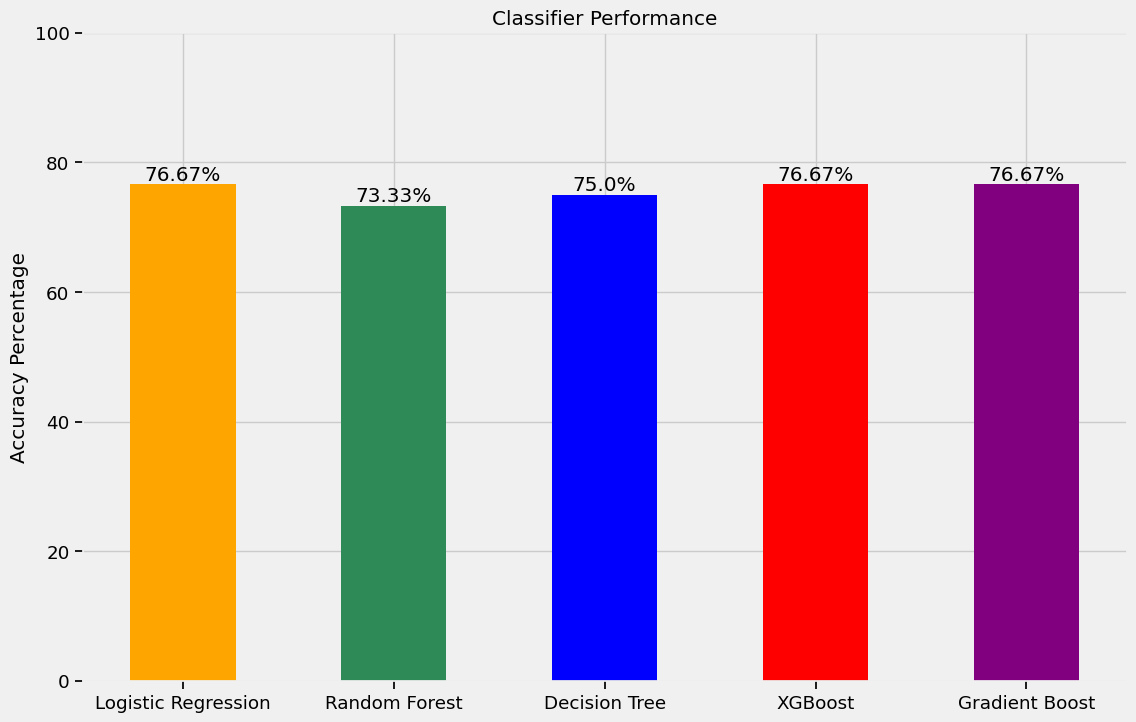

In [63]:
import matplotlib.pyplot as plt

# Data
labels = ['Logistic Regression', 'Random Forest', 'Decision Tree', 'XGBoost', 'Gradient Boost']
percentages = [76.67, 73.33, 75.0, 76.67, 76.67]

# Create bar chart with increased figure size and padding
fig, ax = plt.subplots(figsize=(12, 8))  # Increase figure size
bars = ax.bar(labels, percentages, color=['orange', 'seagreen', 'blue', 'red', 'purple'], width=0.5)

# Display percentages on the bars
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage}%', ha='center', va='bottom')

# Set labels and title
ax.set_ylabel('Accuracy Percentage')
ax.set_title('Classifier Performance')
ax.set_ylim(0, 100)  # Set y-axis limit to 0-100 for percentage

# Add padding
plt.margins(y=0.1)  # Add padding to the top and bottom of the plot area

# Show the bar chart
plt.show()
